In [2]:
# Section 1: Load and Parse Processed Trace Data
import os
import glob
import json

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = 'metrics_0.025_baseline/request_metrics.csv'
df = pd.read_csv(csv_path)

# Compute the ratio of total_tool_time_ms to first_token_render_ms
# Filter out rows where first_token_render_ms is 0 to avoid division by zero
df_filtered = df[df['first_token_render_ms'] > 0].copy()
df_filtered['tool_time_ratio'] = df_filtered['total_tool_time_ms'] / df_filtered['first_token_render_ms']

print(f"Total requests: {len(df)}")
print(f"Requests with valid first_token_render_ms: {len(df_filtered)}")
print(f"\nRatio statistics:")
print(df_filtered['tool_time_ratio'].describe())

Total requests: 60
Requests with valid first_token_render_ms: 60

Ratio statistics:
count    60.000000
mean      0.337904
std       0.240957
min       0.028277
25%       0.175197
50%       0.270571
75%       0.467478
max       0.829856
Name: tool_time_ratio, dtype: float64


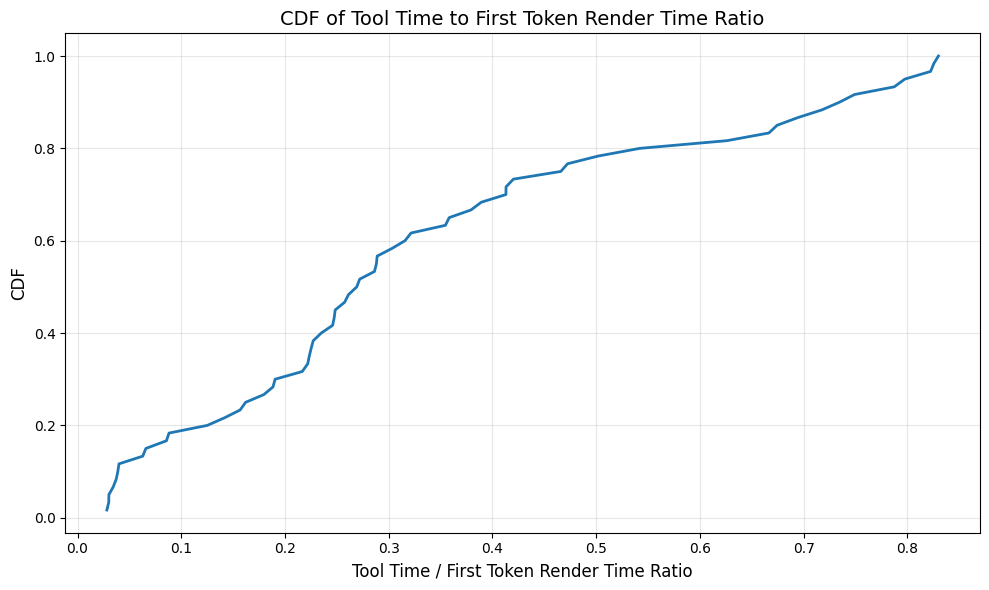


Key percentiles:
P50: 0.271
P75: 0.467
P90: 0.736
P95: 0.799
P99: 0.827


In [4]:
# Plot CDF of tool_time_ratio
sorted_ratios = np.sort(df_filtered['tool_time_ratio'])
cdf = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)

plt.figure(figsize=(10, 6))
plt.plot(sorted_ratios, cdf, linewidth=2)
plt.xlabel('Tool Time / First Token Render Time Ratio', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.title('CDF of Tool Time to First Token Render Time Ratio', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some key percentiles
percentiles = [50, 75, 90, 95, 99]
print("\nKey percentiles:")
for p in percentiles:
    value = np.percentile(df_filtered['tool_time_ratio'], p)
    print(f"P{p}: {value:.3f}")

In [5]:
# Load the JSON file
json_path = 'gpt5_60_poo.json'
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract new_content_start_char_index ratios
new_content_ratios = []

for request in data['requests']:
    for iter_info in request.get('iter_info', []):
        # Check if new_content_start_char_index exists
        if 'new_content_start_char_index' in iter_info:
            new_content_idx = iter_info['new_content_start_char_index']
            prompt_json = iter_info.get('prompt_json', '')
            
            # Calculate total length of prompt_json
            total_prompt_length = len(prompt_json)
            
            if total_prompt_length > 0:
                # Compute ratio
                ratio = new_content_idx / total_prompt_length
                new_content_ratios.append(ratio)

print(f"Total iterations with new_content_start_char_index: {len(new_content_ratios)}")
print(f"\nRatio statistics:")
if new_content_ratios:
    ratios_array = np.array(new_content_ratios)
    print(f"Mean: {ratios_array.mean():.4f}")
    print(f"Median: {np.median(ratios_array):.4f}")
    print(f"Std: {ratios_array.std():.4f}")
    print(f"Min: {ratios_array.min():.4f}")
    print(f"Max: {ratios_array.max():.4f}")
else:
    print("No data found")

Total iterations with new_content_start_char_index: 86

Ratio statistics:
Mean: 0.6787
Median: 0.6800
Std: 0.0597
Min: 0.4969
Max: 0.8121


Ratio statistics:
Mean: 0.6787
Median: 0.6800
Std: 0.0597
Min: 0.4969
Max: 0.8121


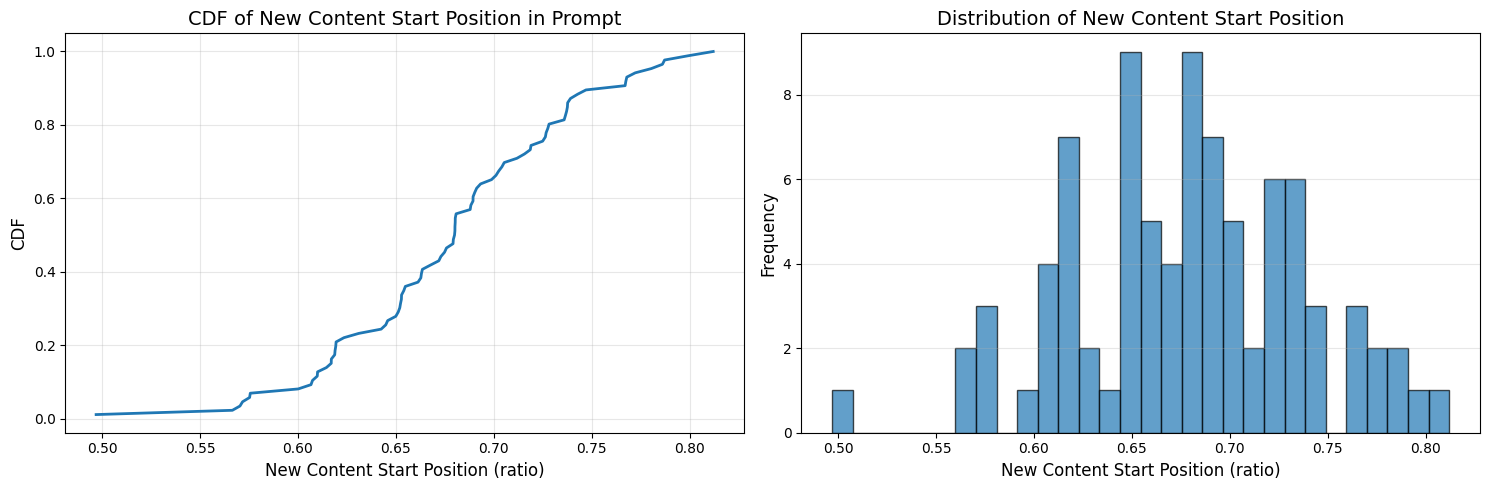


Key percentiles:
P10: 0.6086
P25: 0.6451
P50: 0.6800
P75: 0.7235
P90: 0.7571
P95: 0.7784
P99: 0.8012


In [6]:
# Plot CDF and histogram of new content position ratios
if new_content_ratios:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # CDF plot
    sorted_ratios = np.sort(new_content_ratios)
    cdf = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
    
    ax1.plot(sorted_ratios, cdf, linewidth=2)
    ax1.set_xlabel('New Content Start Position (ratio)', fontsize=12)
    ax1.set_ylabel('CDF', fontsize=12)
    ax1.set_title('CDF of New Content Start Position in Prompt', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Histogram
    ax2.hist(new_content_ratios, bins=30, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('New Content Start Position (ratio)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of New Content Start Position', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print key percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print("\nKey percentiles:")
    for p in percentiles:
        value = np.percentile(new_content_ratios, p)
        print(f"P{p}: {value:.4f}")
else:
    print("No data to plot")

In [7]:
# Load all trace files from processed_traces/processed_trace_tools_suffixed_<x>.json
trace_files = glob.glob('../processed_traces/processed_trace_tools_suffixed_*.json')
print(f"Found {len(trace_files)} trace files.")
# Load json
all_traces = []
for file in trace_files:
    with open(file, 'r', encoding='utf-8') as f:
        trace_data = json.load(f)
        # Each file contains {"requests": [...]}
        all_traces.extend(trace_data['requests'])

Found 6 trace files.


In [8]:
# Extract tool function names and their latencies
from collections import defaultdict

# Dictionary to store latencies per tool function
tool_latencies = defaultdict(list)
response_lengths = defaultdict(list)

# Iterate through all traces (requests) and their iterations
for request in all_traces:
    for iter_info in request.get('iter_info', []):
        # Check if tool_info exists
        tool_info_list = iter_info.get('tool_info', [])
        
        for tool_info in tool_info_list:
            # Extract function name and latency
            function_name = tool_info.get('function')
            latency = tool_info.get('latency')
            response_length = tool_info.get('response_length')

            # Only add if both values exist
            if function_name and latency is not None:
                tool_latencies[function_name].append(latency)
            if function_name and response_length is not None:
                response_lengths[function_name].append(response_length)

# Display summary statistics for each tool
print(f"Total unique tool functions: {len(tool_latencies)}\n")

# Sort tools by count (number of calls)
sorted_tools_by_count = sorted(tool_latencies.items(), key=lambda x: len(x[1]), reverse=True)

for tool_name, latencies in sorted_tools_by_count:
    latencies = np.array(latencies)
    print(f"\n{tool_name}:")
    print(f"  Count: {len(latencies)}")
    print(f"  Mean: {latencies.mean():.2f} ms")
    print(f"  Median: {np.median(latencies):.2f} ms")
    print(f"  Std: {latencies.std():.2f} ms")
    print(f"  Min: {latencies.min():.2f} ms")
    print(f"  Max: {latencies.max():.2f} ms")

# Display summary statistics for response lengths
print(f"\nTotal unique tool functions (response lengths): {len(response_lengths)}\n")

# Sort tools by count (number of calls)
sorted_response_tools = sorted(response_lengths.items(), key=lambda x: len(x[1]), reverse=True)

for tool_name, response_lens in sorted_response_tools:
    response_lens = np.array(response_lens)
    print(f"\n{tool_name}:")
    print(f"  Count: {len(response_lens)}")
    print(f"  Mean: {response_lens.mean():.2f} tokens")
    print(f"  Median: {np.median(response_lens):.2f} tokens")
    print(f"  Std: {response_lens.std():.2f} tokens")
    print(f"  Min: {response_lens.min():.2f} tokens")
    print(f"  Max: {response_lens.max():.2f} tokens")

Total unique tool functions: 18


search_enterprise_files:
  Count: 3867
  Mean: 1048.09 ms
  Median: 946.00 ms
  Std: 1124.22 ms
  Min: 6.00 ms
  Max: 34004.00 ms

office365_search:
  Count: 3091
  Mean: 1577.75 ms
  Median: 1197.00 ms
  Std: 1602.13 ms
  Min: 14.00 ms
  Max: 34422.00 ms

search_enterprise_emails:
  Count: 1362
  Mean: 1185.42 ms
  Median: 958.50 ms
  Std: 1379.31 ms
  Min: 6.00 ms
  Max: 13670.00 ms

meta_prioritize:
  Count: 1336
  Mean: 0.00 ms
  Median: 0.00 ms
  Std: 0.00 ms
  Min: 0.00 ms
  Max: 0.00 ms

search_enterprise_meetings:
  Count: 1303
  Mean: 1187.59 ms
  Median: 985.00 ms
  Std: 1139.91 ms
  Min: 6.00 ms
  Max: 13961.00 ms

search_enterprise_chat:
  Count: 1220
  Mean: 961.42 ms
  Median: 785.50 ms
  Std: 1033.69 ms
  Min: 6.00 ms
  Max: 15396.00 ms

search_enterprise_transcripts:
  Count: 1123
  Mean: 993.71 ms
  Median: 855.00 ms
  Std: 965.46 ms
  Min: 46.00 ms
  Max: 17078.00 ms

summarize_file:
  Count: 584
  Mean: 105.53 ms
  Median: 83.00 ms
 

C:\Users\jamohan\AppData\Local\Temp\ipykernel_27016\328251912.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(normalized_latency_data, labels=tool_names, patch_artist=True)


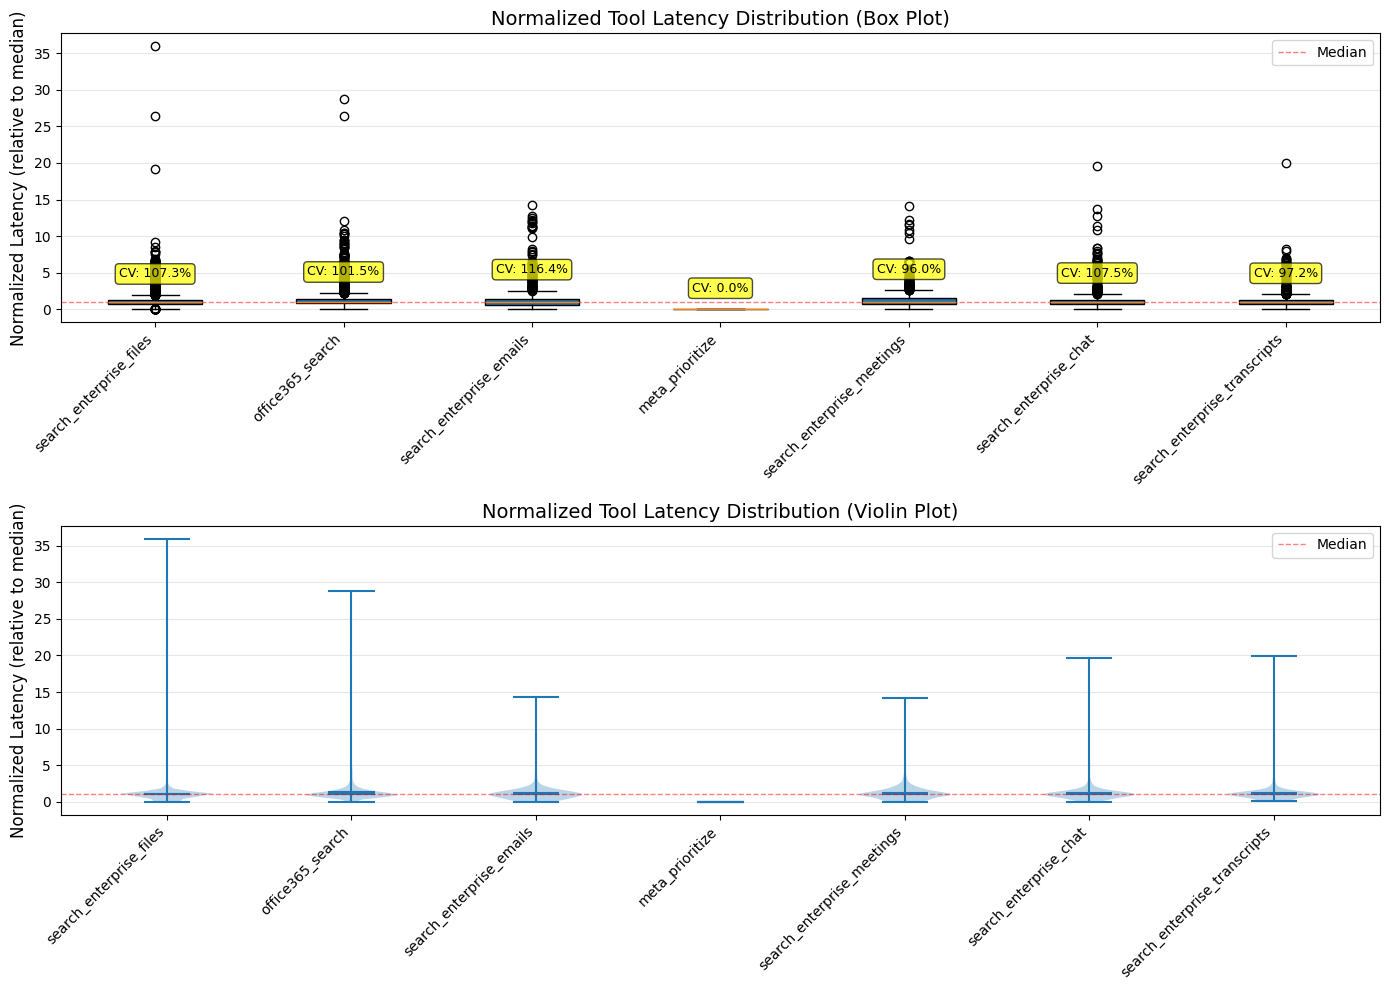

In [9]:
# Visualize normalized tool latency distributions
if tool_latencies:
    # Create box plots for normalized latencies
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Sort tools by count (number of calls)
    sorted_tools = sorted(tool_latencies.items(), 
                         key=lambda x: len(x[1]), 
                         reverse=True)[:7]

    tool_names = [name for name, _ in sorted_tools]
    
    # Normalize latencies for each tool (divide by median)
    normalized_latency_data = []
    cv_values = []
    for _, latencies in sorted_tools:
        latencies_array = np.array(latencies)
        median_latency = np.median(latencies_array)
        if median_latency > 0:
            normalized = latencies_array / median_latency
        else:
            normalized = latencies_array
        normalized_latency_data.append(normalized)
        
        # Calculate CV for each tool
        mean = latencies_array.mean()
        std_dev = latencies_array.std()
        cv = (std_dev / mean * 100.0) if mean > 0 else 0.0
        cv_values.append(cv)
    
    # Box plot
    bp = ax1.boxplot(normalized_latency_data, labels=tool_names, patch_artist=True)
    ax1.set_ylabel('Normalized Latency (relative to median)', fontsize=12)
    ax1.set_title('Normalized Tool Latency Distribution (Box Plot)', fontsize=14)
    ax1.axhline(y=1.0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Median')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add CV values on top of each box plot
    for i, cv in enumerate(cv_values):
        # Get the y-position (max value of the whisker or outliers) and add offset
        y_pos = bp['whiskers'][i*2+1].get_ydata()[1]
        y_offset = (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.05  # 5% of y-axis range
        ax1.text(i+1, y_pos + y_offset, f'CV: {cv:.1f}%', 
                ha='center', va='bottom', fontsize=9, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # Violin plot for better distribution visualization
    vp = ax2.violinplot(normalized_latency_data, positions=range(1, len(tool_names) + 1), 
                        showmeans=True, showmedians=True)
    ax2.set_xticks(range(1, len(tool_names) + 1))
    ax2.set_xticklabels(tool_names)
    ax2.set_ylabel('Normalized Latency (relative to median)', fontsize=12)
    ax2.set_title('Normalized Tool Latency Distribution (Violin Plot)', fontsize=14)
    ax2.axhline(y=1.0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Median')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend()
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
else:
    print("No tool latency data found")

In [10]:
# Print detailed statistics for top 7 tools as a table
if tool_latencies:
    # Sort tools by count (number of calls)
    sorted_tools = sorted(tool_latencies.items(), 
                         key=lambda x: len(x[1]), 
                         reverse=True)[:7]
    
    # Create DataFrame for better table formatting
    table_data = []
    
    for tool_name, latencies in sorted_tools:
        latencies_array = np.array(latencies)
        median = np.median(latencies_array)
        mean = latencies_array.mean()
        p75 = np.percentile(latencies_array, 75)
        p99 = np.percentile(latencies_array, 99)
        std_dev = latencies_array.std()
        
        # Coefficient of Variation (normalized measure of variability)
        cv = (std_dev / mean * 100.0) if mean > 0 else 0.0
        
        # Normalized values (relative to median)
        normalized = latencies_array / median if median > 0 else latencies_array
        norm_p75 = np.percentile(normalized, 75)
        norm_p90 = np.percentile(normalized, 90)
        norm_p99 = np.percentile(normalized, 99)
        
        table_data.append({
            'Tool': tool_name,
            'Count': len(latencies),
            'Median (ms)': f'{median:.2f}',
            'CV (%)': f'{cv:.1f}',
            'Norm P75': f'{norm_p75:.2f}x',
            'Norm P90': f'{norm_p90:.2f}x',
            'Norm P99': f'{norm_p99:.2f}x'
        })
    
    df_stats = pd.DataFrame(table_data)
    
    print("\n" + "=" * 100)
    print("Top 7 Tools - Latency Statistics")
    print("=" * 100)
    print(df_stats.to_string(index=False))
    print("=" * 100)
    print("\nNote: Norm P75/P99 shows percentiles normalized relative to median (median = 1.0x)")


Top 7 Tools - Latency Statistics
                         Tool  Count Median (ms) CV (%) Norm P75 Norm P90 Norm P99
      search_enterprise_files   3867      946.00  107.3    1.23x    1.60x    5.64x
             office365_search   3091     1197.00  101.5    1.36x    2.07x    7.21x
     search_enterprise_emails   1362      958.50  116.4    1.39x    1.99x    8.06x
              meta_prioritize   1336        0.00    0.0    0.00x    0.00x    0.00x
   search_enterprise_meetings   1303      985.00   96.0    1.46x    2.09x    6.36x
       search_enterprise_chat   1220      785.50  107.5    1.29x    1.82x    6.90x
search_enterprise_transcripts   1123      855.00   97.2    1.27x    1.72x    6.23x

Note: Norm P75/P99 shows percentiles normalized relative to median (median = 1.0x)


Total requests analyzed: 5975
Total iterations analyzed: 6535

Iteration Depth Statistics (iterations per request)
Mean: 2.09
Median: 2.00
Std: 0.42
Min: 0
Max: 7
P75: 2.00
P90: 2.00
P99: 4.00

Tool Fan-Out Statistics (tool calls per iteration)
Mean: 2.31
Median: 2.00
Std: 1.82
Min: 1
Max: 21
P75: 3.00
P90: 5.00
P99: 8.00


C:\Users\jamohan\AppData\Local\Temp\ipykernel_27016\3826694016.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot([iter_depths], labels=['Iteration Depth'], patch_artist=True)
C:\Users\jamohan\AppData\Local\Temp\ipykernel_27016\3826694016.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot([tool_fan_outs], labels=['Tool Fan-Out'], patch_artist=True,


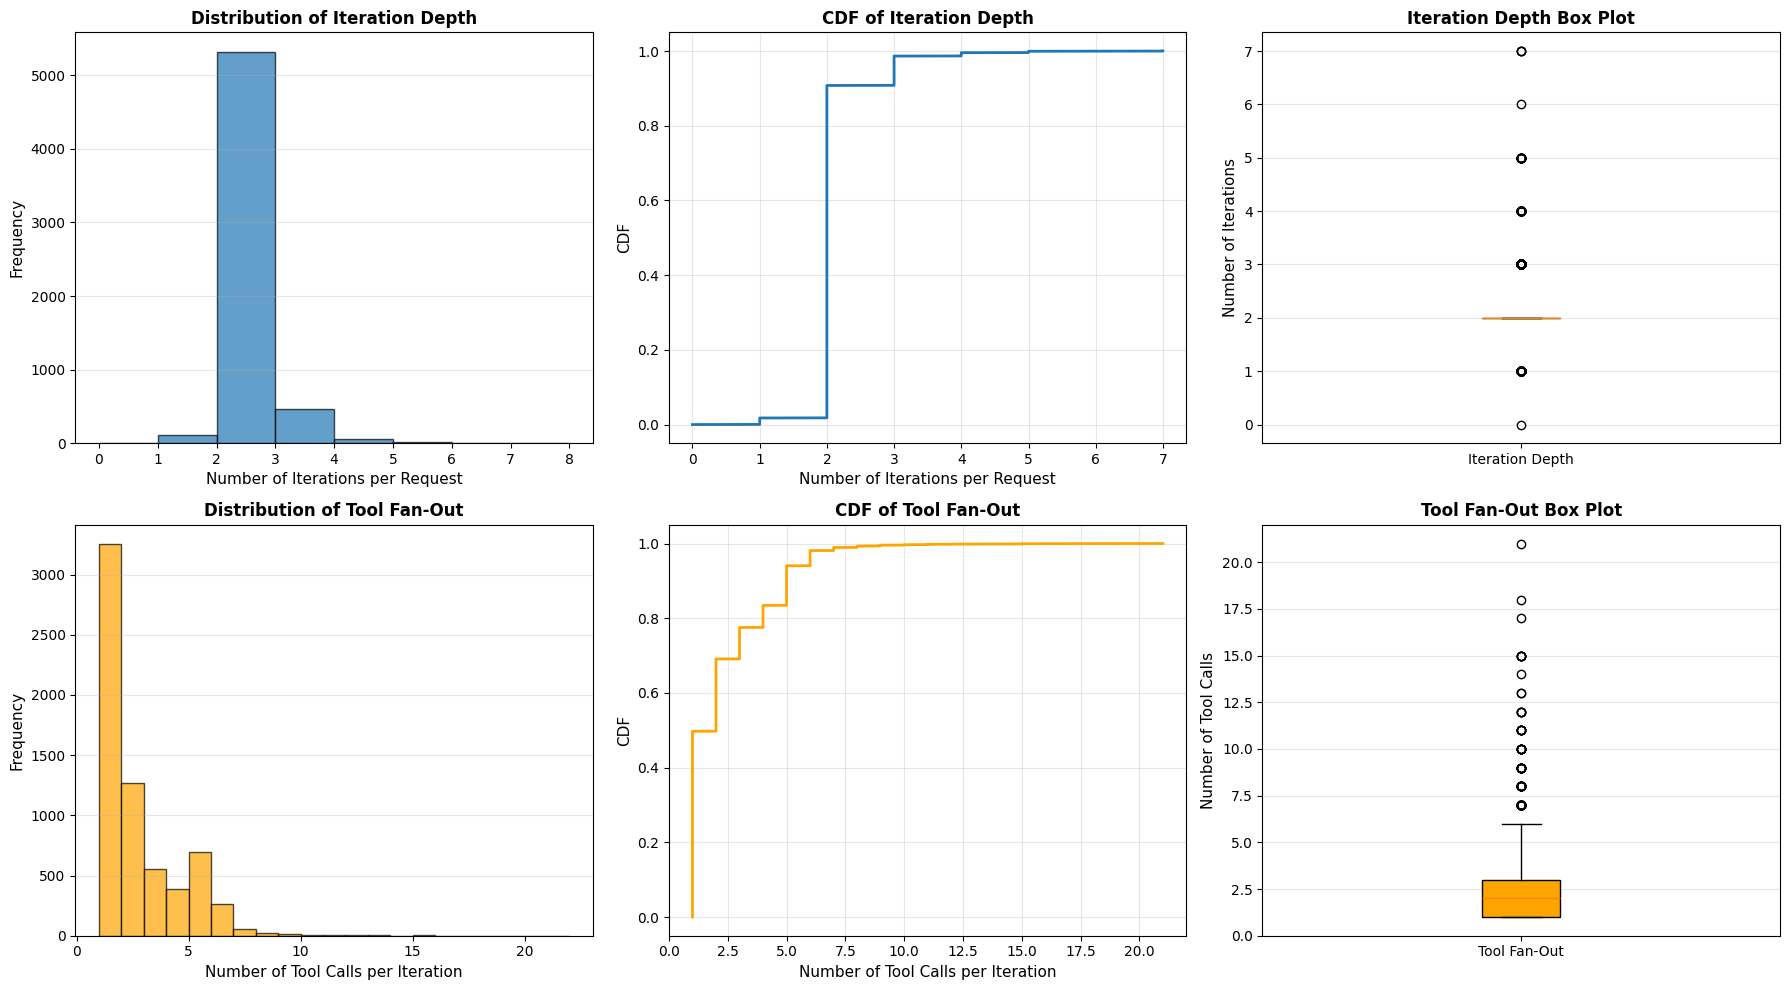

In [11]:
# Analyze iteration depth and tool fan-out
# iter_depth = number of iterations per request
# tool_fan_out = number of tool calls per iteration of a request

iter_depths = []  # Number of iterations per request
tool_fan_outs = []  # Number of tool calls per iteration (across all requests)

for request in all_traces:
    iter_info_list = request.get('iter_info', [])
    
    # iter_depth: count only iterations of type tool_decode or response_decode
    iter_depth = 0
    for iter_info in iter_info_list:
        iter_type = iter_info.get('iter_type', '')
        model = iter_info.get("model", '')  #: "GPT-4",
        if iter_type in ['TOOL_DECODE', 'RESPONSE_DECODE'] and model.startswith("GPT-"):
            iter_depth += 1
    
    iter_depths.append(iter_depth)
    
    # tool_fan_out: number of tool calls per iteration
    for iter_info in iter_info_list:
        tool_info_list = iter_info.get('tool_info', [])
        tool_fan_out = len(tool_info_list)
        model = iter_info.get("model", '')  #: "GPT-4",
        if iter_info.get('iter_type', '') in ['TOOL_DECODE'] and model.startswith("GPT-"):
            tool_fan_outs.append(tool_fan_out)

# Convert to numpy arrays
iter_depths = np.array(iter_depths)
tool_fan_outs = np.array(tool_fan_outs)

print(f"Total requests analyzed: {len(iter_depths)}")
print(f"Total iterations analyzed: {len(tool_fan_outs)}")

print("\n" + "=" * 60)
print("Iteration Depth Statistics (iterations per request)")
print("=" * 60)
print(f"Mean: {iter_depths.mean():.2f}")
print(f"Median: {np.median(iter_depths):.2f}")
print(f"Std: {iter_depths.std():.2f}")
print(f"Min: {iter_depths.min()}")
print(f"Max: {iter_depths.max()}")
print(f"P75: {np.percentile(iter_depths, 75):.2f}")
print(f"P90: {np.percentile(iter_depths, 90):.2f}")
print(f"P99: {np.percentile(iter_depths, 99):.2f}")

print("\n" + "=" * 60)
print("Tool Fan-Out Statistics (tool calls per iteration)")
print("=" * 60)
print(f"Mean: {tool_fan_outs.mean():.2f}")
print(f"Median: {np.median(tool_fan_outs):.2f}")
print(f"Std: {tool_fan_outs.std():.2f}")
print(f"Min: {tool_fan_outs.min()}")
print(f"Max: {tool_fan_outs.max()}")
print(f"P75: {np.percentile(tool_fan_outs, 75):.2f}")
print(f"P90: {np.percentile(tool_fan_outs, 90):.2f}")
print(f"P99: {np.percentile(tool_fan_outs, 99):.2f}")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Iteration Depth
# Histogram
axes[0, 0].hist(iter_depths, bins=range(int(iter_depths.min()), int(iter_depths.max()) + 2), 
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Iterations per Request', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Iteration Depth', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# CDF
sorted_depths = np.sort(iter_depths)
cdf_depths = np.arange(1, len(sorted_depths) + 1) / len(sorted_depths)
axes[0, 1].plot(sorted_depths, cdf_depths, linewidth=2)
axes[0, 1].set_xlabel('Number of Iterations per Request', fontsize=11)
axes[0, 1].set_ylabel('CDF', fontsize=11)
axes[0, 1].set_title('CDF of Iteration Depth', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Box plot
axes[0, 2].boxplot([iter_depths], labels=['Iteration Depth'], patch_artist=True)
axes[0, 2].set_ylabel('Number of Iterations', fontsize=11)
axes[0, 2].set_title('Iteration Depth Box Plot', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Row 2: Tool Fan-Out
# Histogram
axes[1, 0].hist(tool_fan_outs, bins=range(int(tool_fan_outs.min()), int(tool_fan_outs.max()) + 2), 
                edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Number of Tool Calls per Iteration', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Tool Fan-Out', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# CDF
sorted_fanouts = np.sort(tool_fan_outs)
cdf_fanouts = np.arange(1, len(sorted_fanouts) + 1) / len(sorted_fanouts)
axes[1, 1].plot(sorted_fanouts, cdf_fanouts, linewidth=2, color='orange')
axes[1, 1].set_xlabel('Number of Tool Calls per Iteration', fontsize=11)
axes[1, 1].set_ylabel('CDF', fontsize=11)
axes[1, 1].set_title('CDF of Tool Fan-Out', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Box plot
axes[1, 2].boxplot([tool_fan_outs], labels=['Tool Fan-Out'], patch_artist=True,
                   boxprops=dict(facecolor='orange'))
axes[1, 2].set_ylabel('Number of Tool Calls', fontsize=11)
axes[1, 2].set_title('Tool Fan-Out Box Plot', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

TOOL_DECODE Iterations - Prompt Length Statistics
Count: 6544
Mean: 18626.51
Median: 20632.00
Std: 6111.70
Min: 6325
Max: 44528
P50: 20632.00
P75: 23932.00
P90: 25563.80
P99: 28660.25

TOOL_DECODE Iterations - Response Length Statistics
Count: 6544
Mean: 232.43
Median: 186.00
Std: 156.81
Min: 3
Max: 1591
P50: 186.00
P75: 336.00
P90: 418.00
P99: 750.85

RESPONSE_DECODE Iterations - Prompt Length Statistics
Count: 5974
Mean: 22382.77
Median: 23408.50
Std: 7121.24
Min: 8623
Max: 52680
P50: 23408.50
P75: 27086.75
P90: 30469.30
P99: 41159.01

RESPONSE_DECODE Iterations - Response Length Statistics
Count: 5974
Mean: 501.92
Median: 500.00
Std: 307.01
Min: 21
Max: 1862
P50: 500.00
P75: 725.00
P90: 911.00
P99: 1248.27


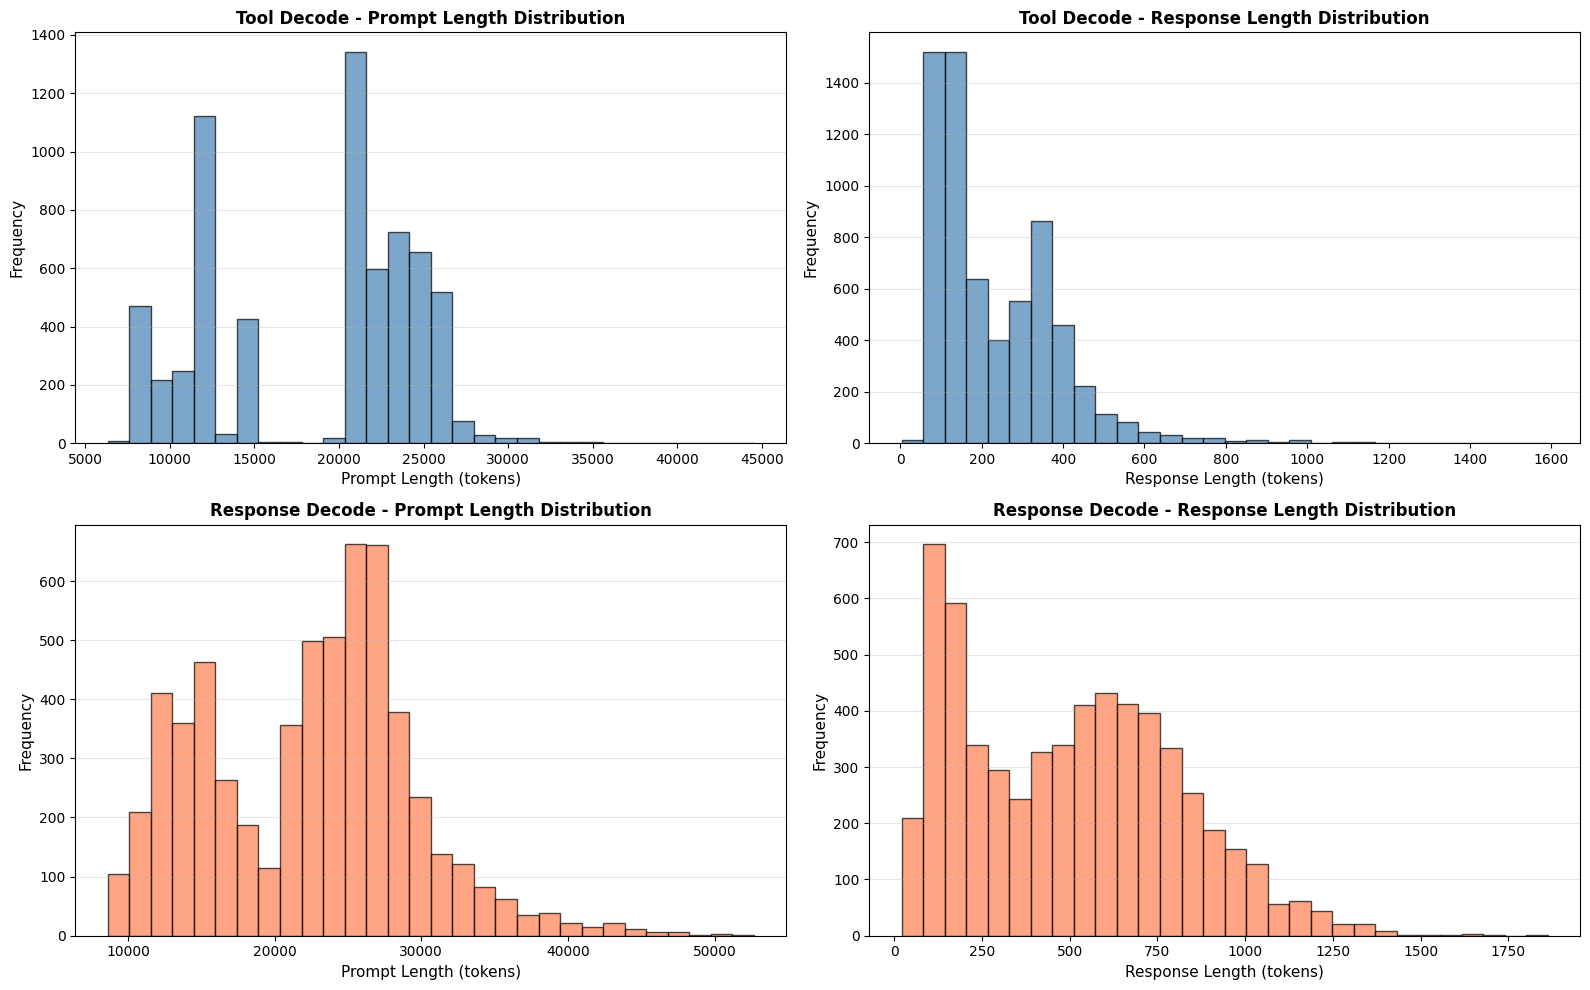

In [12]:
# Analyze prompt_length and response_length for tool_decode and response_decode iterations

tool_decode_prompt_lengths = []
tool_decode_response_lengths = []
response_decode_prompt_lengths = []
response_decode_response_lengths = []

for request in all_traces:
    iter_info_list = request.get('iter_info', [])
    
    for iter_info in iter_info_list:
        iter_type = iter_info.get('iter_type', '')
        prompt_length = iter_info.get('prompt_length')
        response_length = iter_info.get('response_length')
        
        if iter_type == 'TOOL_DECODE':
            if prompt_length is not None:
                tool_decode_prompt_lengths.append(prompt_length)
            if response_length is not None:
                tool_decode_response_lengths.append(response_length)
        
        elif iter_type == 'RESPONSE_DECODE':
            if prompt_length is not None:
                response_decode_prompt_lengths.append(prompt_length)
            if response_length is not None:
                response_decode_response_lengths.append(response_length)

# Convert to numpy arrays
tool_decode_prompt_lengths = np.array(tool_decode_prompt_lengths)
tool_decode_response_lengths = np.array(tool_decode_response_lengths)
response_decode_prompt_lengths = np.array(response_decode_prompt_lengths)
response_decode_response_lengths = np.array(response_decode_response_lengths)

# Print statistics
print("=" * 80)
print("TOOL_DECODE Iterations - Prompt Length Statistics")
print("=" * 80)
if len(tool_decode_prompt_lengths) > 0:
    print(f"Count: {len(tool_decode_prompt_lengths)}")
    print(f"Mean: {tool_decode_prompt_lengths.mean():.2f}")
    print(f"Median: {np.median(tool_decode_prompt_lengths):.2f}")
    print(f"Std: {tool_decode_prompt_lengths.std():.2f}")
    print(f"Min: {tool_decode_prompt_lengths.min()}")
    print(f"Max: {tool_decode_prompt_lengths.max()}")
    print(f"P50: {np.percentile(tool_decode_prompt_lengths, 50):.2f}")
    print(f"P75: {np.percentile(tool_decode_prompt_lengths, 75):.2f}")
    print(f"P90: {np.percentile(tool_decode_prompt_lengths, 90):.2f}")
    print(f"P99: {np.percentile(tool_decode_prompt_lengths, 99):.2f}")
else:
    print("No data found")

print("\n" + "=" * 80)
print("TOOL_DECODE Iterations - Response Length Statistics")
print("=" * 80)
if len(tool_decode_response_lengths) > 0:
    print(f"Count: {len(tool_decode_response_lengths)}")
    print(f"Mean: {tool_decode_response_lengths.mean():.2f}")
    print(f"Median: {np.median(tool_decode_response_lengths):.2f}")
    print(f"Std: {tool_decode_response_lengths.std():.2f}")
    print(f"Min: {tool_decode_response_lengths.min()}")
    print(f"Max: {tool_decode_response_lengths.max()}")
    print(f"P50: {np.percentile(tool_decode_response_lengths, 50):.2f}")
    print(f"P75: {np.percentile(tool_decode_response_lengths, 75):.2f}")
    print(f"P90: {np.percentile(tool_decode_response_lengths, 90):.2f}")
    print(f"P99: {np.percentile(tool_decode_response_lengths, 99):.2f}")
else:
    print("No data found")

print("\n" + "=" * 80)
print("RESPONSE_DECODE Iterations - Prompt Length Statistics")
print("=" * 80)
if len(response_decode_prompt_lengths) > 0:
    print(f"Count: {len(response_decode_prompt_lengths)}")
    print(f"Mean: {response_decode_prompt_lengths.mean():.2f}")
    print(f"Median: {np.median(response_decode_prompt_lengths):.2f}")
    print(f"Std: {response_decode_prompt_lengths.std():.2f}")
    print(f"Min: {response_decode_prompt_lengths.min()}")
    print(f"Max: {response_decode_prompt_lengths.max()}")
    print(f"P50: {np.percentile(response_decode_prompt_lengths, 50):.2f}")
    print(f"P75: {np.percentile(response_decode_prompt_lengths, 75):.2f}")
    print(f"P90: {np.percentile(response_decode_prompt_lengths, 90):.2f}")
    print(f"P99: {np.percentile(response_decode_prompt_lengths, 99):.2f}")
else:
    print("No data found")

print("\n" + "=" * 80)
print("RESPONSE_DECODE Iterations - Response Length Statistics")
print("=" * 80)
if len(response_decode_response_lengths) > 0:
    print(f"Count: {len(response_decode_response_lengths)}")
    print(f"Mean: {response_decode_response_lengths.mean():.2f}")
    print(f"Median: {np.median(response_decode_response_lengths):.2f}")
    print(f"Std: {response_decode_response_lengths.std():.2f}")
    print(f"Min: {response_decode_response_lengths.min()}")
    print(f"Max: {response_decode_response_lengths.max()}")
    print(f"P50: {np.percentile(response_decode_response_lengths, 50):.2f}")
    print(f"P75: {np.percentile(response_decode_response_lengths, 75):.2f}")
    print(f"P90: {np.percentile(response_decode_response_lengths, 90):.2f}")
    print(f"P99: {np.percentile(response_decode_response_lengths, 99):.2f}")
else:
    print("No data found")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Tool Decode - Prompt Length
if len(tool_decode_prompt_lengths) > 0:
    axes[0, 0].hist(tool_decode_prompt_lengths, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].set_xlabel('Prompt Length (tokens)', fontsize=11)
    axes[0, 0].set_ylabel('Frequency', fontsize=11)
    axes[0, 0].set_title('Tool Decode - Prompt Length Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

# Tool Decode - Response Length
if len(tool_decode_response_lengths) > 0:
    axes[0, 1].hist(tool_decode_response_lengths, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 1].set_xlabel('Response Length (tokens)', fontsize=11)
    axes[0, 1].set_ylabel('Frequency', fontsize=11)
    axes[0, 1].set_title('Tool Decode - Response Length Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')

# Response Decode - Prompt Length
if len(response_decode_prompt_lengths) > 0:
    axes[1, 0].hist(response_decode_prompt_lengths, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 0].set_xlabel('Prompt Length (tokens)', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontsize=11)
    axes[1, 0].set_title('Response Decode - Prompt Length Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

# Response Decode - Response Length
if len(response_decode_response_lengths) > 0:
    axes[1, 1].hist(response_decode_response_lengths, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 1].set_xlabel('Response Length (tokens)', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title('Response Decode - Response Length Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

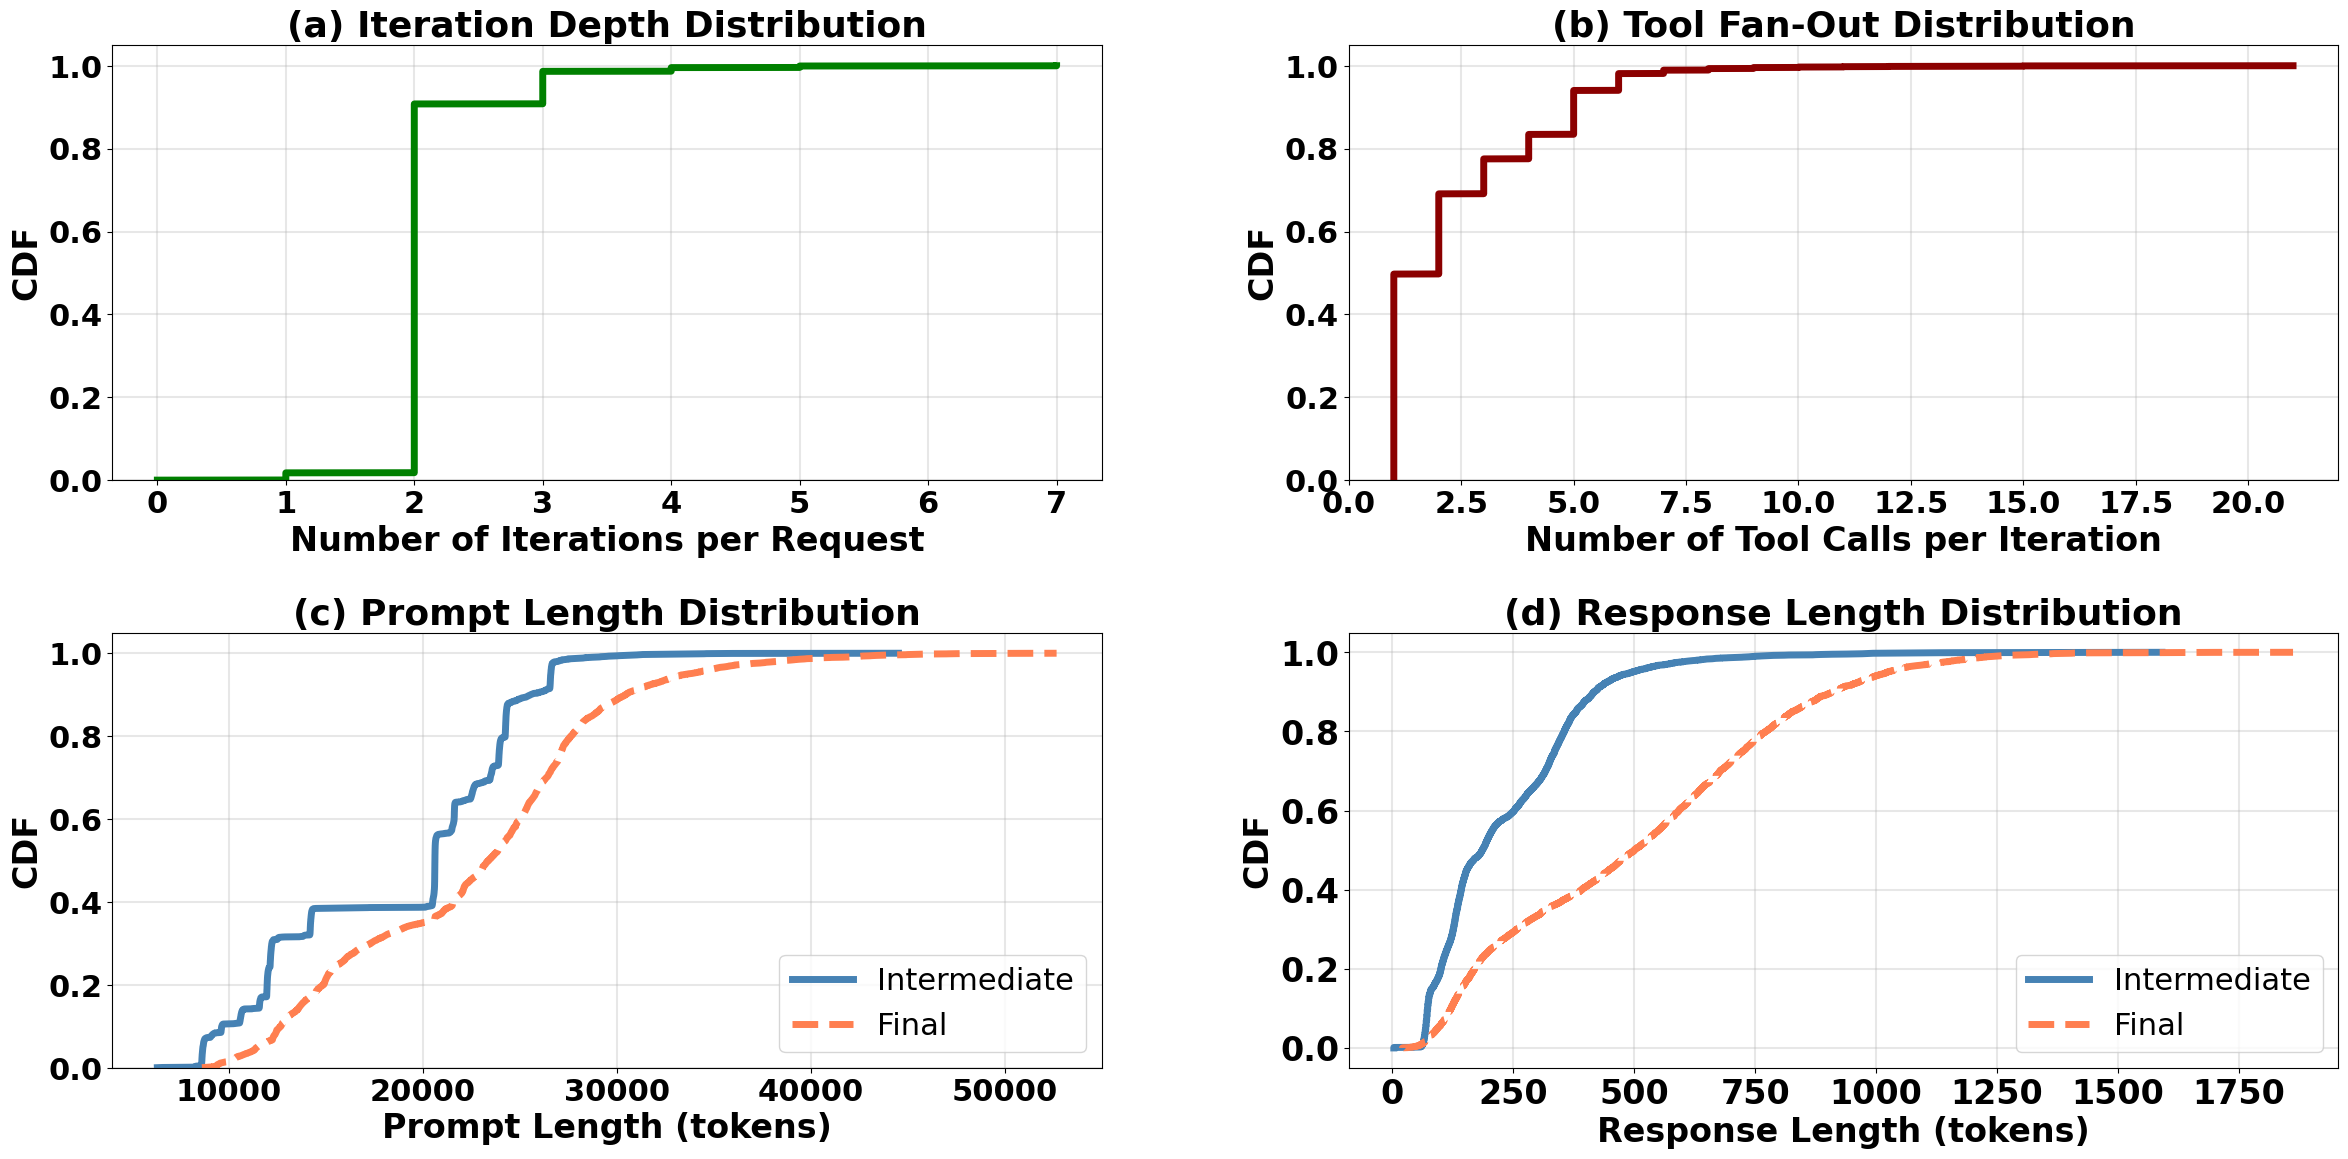

In [ ]:
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.family': 'Sans Serif'})

fig, axes = plt.subplots(2, 2, figsize=(24, 12))

# Define colors matching paper style
color_primary = 'green'
color_secondary = 'darkred'
color_intermediate = 'steelblue'
color_final = 'coral'

# Top-left: Iteration Depth CDF
sorted_depths = np.sort(iter_depths)
cdf_depths = np.arange(1, len(sorted_depths) + 1) / len(sorted_depths)
axes[0, 0].plot(sorted_depths, cdf_depths, linewidth=5, color=color_primary)
axes[0, 0].set_xlabel('Number of Iterations per Request', fontweight='bold', fontsize=24)
axes[0, 0].set_ylabel('CDF', fontweight='bold', fontsize=24)
axes[0, 0].set_title('(a) Iteration Depth Distribution', fontsize=26, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, linewidth=1.5)
axes[0, 0].set_ylim([0, 1.05])
axes[0, 0].tick_params(axis='both', labelsize=22)
for label in axes[0, 0].get_xticklabels() + axes[0, 0].get_yticklabels():
    label.set_fontweight('bold')

# Top-right: Tool Fan-Out CDF
sorted_fanouts = np.sort(tool_fan_outs)
cdf_fanouts = np.arange(1, len(sorted_fanouts) + 1) / len(sorted_fanouts)
axes[0, 1].plot(sorted_fanouts, cdf_fanouts, linewidth=5, color=color_secondary)
axes[0, 1].set_xlabel('Number of Tool Calls per Iteration', fontweight='bold', fontsize=24)
axes[0, 1].set_ylabel('CDF', fontweight='bold', fontsize=24)
axes[0, 1].set_title('(b) Tool Fan-Out Distribution', fontsize=26, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, linewidth=1.5)
axes[0, 1].set_ylim([0, 1.05])
axes[0, 1].tick_params(axis='both', labelsize=22)
for label in axes[0, 1].get_xticklabels() + axes[0, 1].get_yticklabels():
    label.set_fontweight('bold')
axes[0, 1].set_xlabel('Number of Tool Calls per Iteration', fontweight='bold', fontsize=24)
axes[0, 1].set_ylabel('CDF', fontweight='bold', fontsize=24)
axes[0, 1].set_title('(b) Tool Fan-Out Distribution', fontsize=26, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, linewidth=1.5)
axes[0, 1].set_ylim([0, 1.05])
axes[0, 1].tick_params(axis='both', labelsize=22)

# Bottom-left: Prompt Length CDF Comparison
if len(tool_decode_prompt_lengths) > 0:
    sorted_tool_prompts = np.sort(tool_decode_prompt_lengths)
    cdf_tool_prompts = np.arange(1, len(sorted_tool_prompts) + 1) / len(sorted_tool_prompts)
    axes[1, 0].plot(sorted_tool_prompts, cdf_tool_prompts, linewidth=5, label='Intermediate', 
                    color=color_intermediate)

if len(response_decode_prompt_lengths) > 0:
    sorted_response_prompts = np.sort(response_decode_prompt_lengths)
    cdf_response_prompts = np.arange(1, len(sorted_response_prompts) + 1) / len(sorted_response_prompts)
    axes[1, 0].plot(sorted_response_prompts, cdf_response_prompts, linewidth=5, label='Final', 
                    color=color_final, linestyle='--')

axes[1, 0].set_xlabel('Prompt Length (tokens)', fontweight='bold', fontsize=24)
axes[1, 0].set_ylabel('CDF', fontweight='bold', fontsize=24)
axes[1, 0].set_title('(c) Prompt Length Distribution', fontsize=26, fontweight='bold')
axes[1, 0].legend(fontsize=22, loc='lower right', frameon=True)
axes[1, 0].grid(True, alpha=0.3, linewidth=1.5)
axes[1, 0].set_ylim([0, 1.05])
axes[1, 0].tick_params(axis='both', labelsize=22)
for label in axes[1, 0].get_xticklabels() + axes[1, 0].get_yticklabels():
    label.set_fontweight('bold')

# Bottom-right: Response Length CDF Comparison
if len(tool_decode_response_lengths) > 0:
    sorted_tool_responses = np.sort(tool_decode_response_lengths)
    cdf_tool_responses = np.arange(1, len(sorted_tool_responses) + 1) / len(sorted_tool_responses)
    axes[1, 1].plot(sorted_tool_responses, cdf_tool_responses, linewidth=5, label='Intermediate', 
                    color=color_intermediate)

if len(response_decode_response_lengths) > 0:
    sorted_response_responses = np.sort(response_decode_response_lengths)
    cdf_response_responses = np.arange(1, len(sorted_response_responses) + 1) / len(sorted_response_responses)
    axes[1, 1].plot(sorted_response_responses, cdf_response_responses, linewidth=5, label='Final', 
                    color=color_final, linestyle='--')

axes[1, 1].set_xlabel('Response Length (tokens)', fontweight='bold', fontsize=24)
axes[1, 1].set_ylabel('CDF', fontweight='bold', fontsize=24)
axes[1, 1].set_title('(d) Response Length Distribution', fontsize=26, fontweight='bold')
axes[1, 1].legend(fontsize=22, loc='lower right', frameon=True)
axes[1, 1].grid(True, alpha=0.3, linewidth=1.5)
for label in axes[1, 1].get_xticklabels() + axes[1, 1].get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.35, wspace=0.25)
plt.savefig("iteration_analysis_combined.png", bbox_inches='tight', dpi=300)
plt.show()

C:\Users\jamohan\AppData\Local\Temp\ipykernel_27016\428919344.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(normalized_latency_data, labels=letter_labels, patch_artist=True)


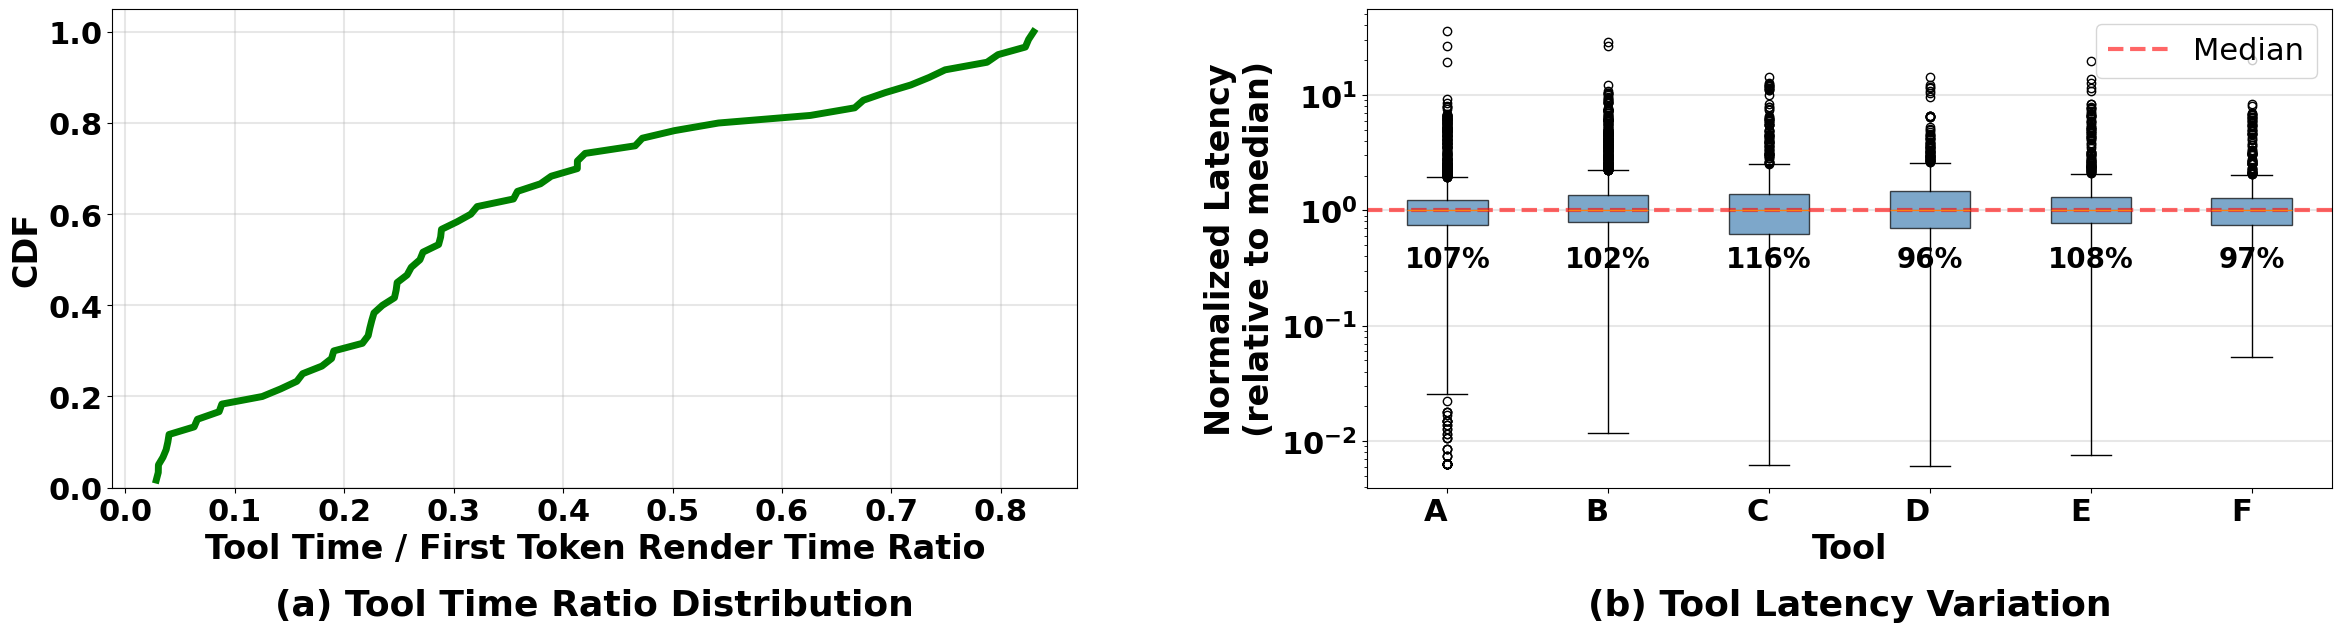

In [ ]:

plt.rcParams.update({'font.size': 26})
plt.rcParams.update({'font.family': 'Sans Serif'})

fig, axes = plt.subplots(1, 2, figsize=(24, 7))

# Define colors matching paper style
color_primary = 'green'
color_box = 'steelblue'

# (a) CDF of Tool Time to First Token Render Time Ratio
sorted_ratios = np.sort(df_filtered['tool_time_ratio'])
cdf = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)

axes[0].plot(sorted_ratios, cdf, linewidth=5, color=color_primary)
axes[0].set_xlabel('Tool Time / First Token Render Time Ratio', fontsize=24, fontweight='bold')
axes[0].set_ylabel('CDF', fontsize=24, fontweight='bold')
axes[0].grid(True, alpha=0.3, linewidth=1.5)
axes[0].set_ylim([0, 1.05])
axes[0].tick_params(axis='both', labelsize=22)
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    label.set_fontweight('bold')

# Add title at the bottom for plot (a)
axes[0].set_title('(a) Tool Time Ratio Distribution', fontsize=26, fontweight='bold', 
                 pad=-40, y=-0.15, loc='center')

# (b) Normalized Tool Latency Variation
if tool_latencies:
    # Sort tools by count (number of calls)
    sorted_tools = sorted(tool_latencies.items(), 
                         key=lambda x: len(x[1]), 
                         reverse=True)[:7]

    tool_names = [name for name, _ in sorted_tools]
    
    # Remove tool D (index 3) from the list
    sorted_tools = sorted_tools[:3] + sorted_tools[4:]
    tool_names = tool_names[:3] + tool_names[4:]
    
    # Create letter labels for x-axis (A through F)
    letter_labels = ['A', 'B', 'C', 'D', 'E', 'F']
    
    # Normalize latencies for each tool (divide by median)
    normalized_latency_data = []
    cv_values = []
    for _, latencies in sorted_tools:
        latencies_array = np.array(latencies)
        median_latency = np.median(latencies_array)
        if median_latency > 0:
            normalized = latencies_array / median_latency
        else:
            normalized = latencies_array
        normalized_latency_data.append(normalized)
        
        # Calculate CV for each tool
        mean = latencies_array.mean()
        std_dev = latencies_array.std()
        cv = (std_dev / mean * 100.0) if mean > 0 else 0.0
        cv_values.append(cv)
    
    # Box plot with letter labels
    bp = axes[1].boxplot(normalized_latency_data, labels=letter_labels, patch_artist=True)
    
    # Style the box plot
    for patch in bp['boxes']:
        patch.set_facecolor(color_box)
        patch.set_alpha(0.7)
    
    axes[1].set_ylabel('Normalized Latency\n(relative to median)', fontsize=24, fontweight='bold')
    axes[1].set_xlabel('Tool', fontsize=24, fontweight='bold')
    axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=3, alpha=0.6, label='Median')
    axes[1].grid(True, alpha=0.3, axis='y', linewidth=1.5)
    axes[1].tick_params(axis='both', labelsize=22)
    axes[1].legend(fontsize=22, loc='upper right', frameon=True)
    axes[1].set_yscale('log')
    plt.setp(axes[1].xaxis.get_majorticklabels(), ha='right', fontweight='bold')
    for label in axes[1].get_yticklabels():
        label.set_fontweight('bold')
    
    # Add CV values below the median line
    for i, cv in enumerate(cv_values):
        # Position labels further below the median line (y=1.0)
        y_pos = 0.5  # Fixed position further below median
        axes[1].text(i+1, y_pos, f'{cv:.0f}%', 
                ha='center', va='top', fontsize=20, fontweight='bold')
    
    # Add title at the bottom
    axes[1].set_title('(b) Tool Latency Variation', fontsize=26, fontweight='bold', 
                     pad=-40, y=-0.15, loc='center')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig("tool_time_analysis_combined.pdf", bbox_inches='tight')
plt.savefig("tool_time_analysis_combined.png", bbox_inches='tight', dpi=300)
plt.show()

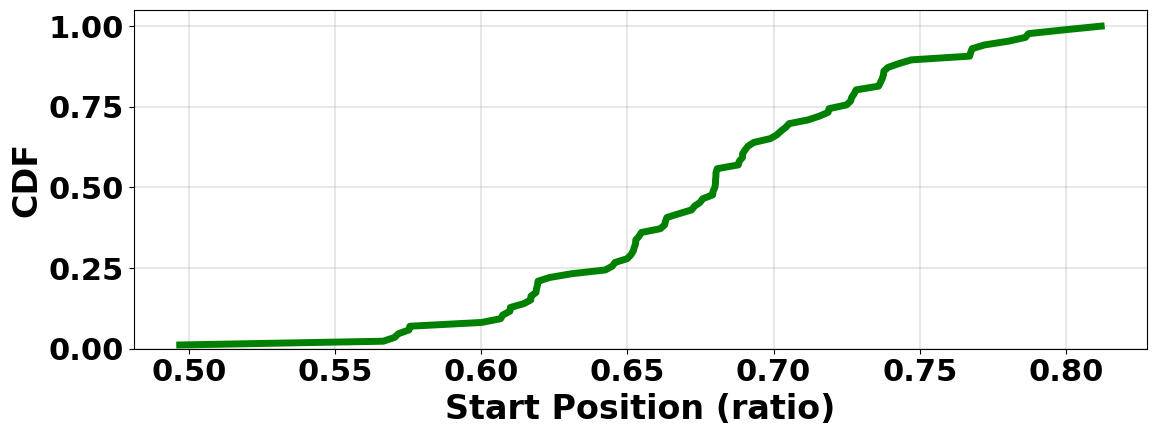

In [ ]:

if new_content_ratios:
    # Update matplotlib style to match paper
    plt.rcParams.update({'font.size': 28})
    plt.rcParams.update({'font.family': 'Sans Serif'})
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    
    # Define color matching paper style
    color_primary = 'green'
    
    # CDF plot
    sorted_ratios = np.sort(new_content_ratios)
    cdf = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
    
    ax.plot(sorted_ratios, cdf, linewidth=5, color=color_primary)
    ax.set_xlabel('Start Position (ratio)', fontsize=24, fontweight='bold')
    ax.set_ylabel('CDF', fontsize=24, fontweight='bold')
    ax.grid(True, alpha=0.3, linewidth=1.5)
    ax.set_ylim([0, 1.05])
    ax.tick_params(axis='both', labelsize=22)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    
    # # Add title at the bottom
    # ax.set_title('New Content Start Position Distribution', fontsize=26, fontweight='bold', 
    #              pad=-40, y=-0.15, loc='center')
    
    plt.tight_layout()
    plt.savefig("new_content_position_cdf.pdf", bbox_inches='tight')
    plt.savefig("new_content_position_cdf.png", bbox_inches='tight', dpi=300)
    plt.show()
    